# ASTR3110 Tutorial 6: Clustering with Gaussian Mixture Models

Tutorial 7 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand the basic Gaussian Mixture modelling technqiue.
 * Use the Scikit Learn clustering algorithm to find clusters in 2D data.
 * Test the behaviour GMM clustering with different assumptions.

## Setup

This week, we won't need to access any data on disk, so simply start a new *Python 3* notebook on Google Colab.The tutorial content is based on a section of the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas. Additional content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

## Introduction to GMMs

In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.
One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.

In [3]:
# Import necessary modules and set plots to appear inline.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs as blobs
from sklearn.cluster import KMeans
%matplotlib inline

In [4]:
# Generate some data
data, clusterID = blobs(n_samples=400, 
                       centers=4,
                       cluster_std=0.60, 
                       random_state=0)

# Swap X and Y axes for better plotting
data = data[:, ::-1] # flip axes for better plotting

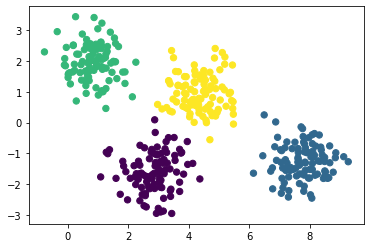

In [5]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
myKM = KMeans(n_clusters=4, random_state=0)
clusters = myKM.fit(data).predict(data)
plt.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='viridis');

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [6]:
from scipy.spatial.distance import cdist

def plot_kmeans(myKM, data, n_clusters=4, rseed=0, ax=None):
    clusters = myKM.fit_predict(data)

    # Plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='jet', zorder=2)

    # Plot the representation of the KMeans model
    centers = myKM.cluster_centers_
    radii = [cdist(data[clusters == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', ec='k', lw=3, alpha=0.5, zorder=1))

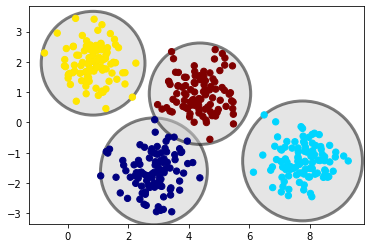

In [7]:
myKM = KMeans(n_clusters=4, random_state=0)
plot_kmeans(myKM, data)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

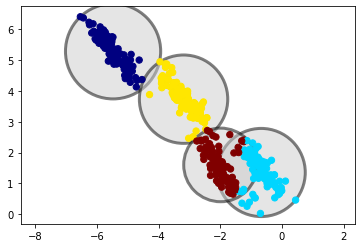

In [8]:
# Stretch the Y-axis
rng = np.random.RandomState(13)
dataLong = np.dot(data, rng.randn(2, 2))

myKM = KMeans(n_clusters=4, random_state=0)
plot_kmeans(myKM, dataLong)

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

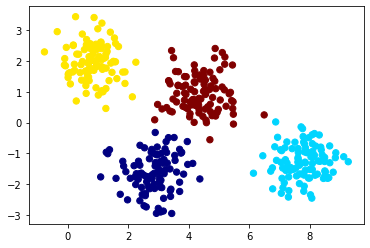

In [19]:
from sklearn.mixture import GaussianMixture as GMM

myGMM = GMM(n_components=4)
myGMM.fit(data)
clusters = myGMM.predict(data)


plt.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='jet');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [20]:
probs = myGMM.predict_proba(data)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


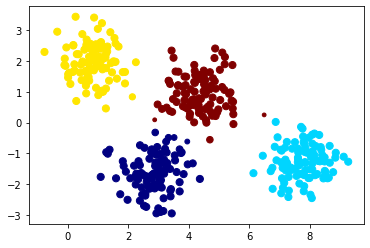

In [21]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='jet', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [22]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [23]:

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        print(pos.shape, covar.shape)
        draw_ellipse(pos, covar, alpha=w * w_factor, ec='k')

(2,) (2, 2)
(2,) (2, 2)


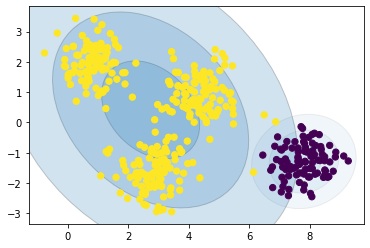

In [24]:
gmm = GMM(n_components=2, random_state=42)
plot_gmm(gmm, data)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

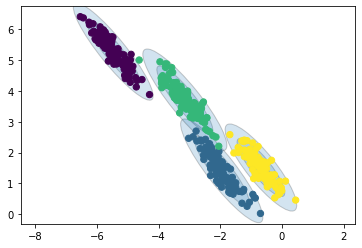

In [13]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, dataLong)

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

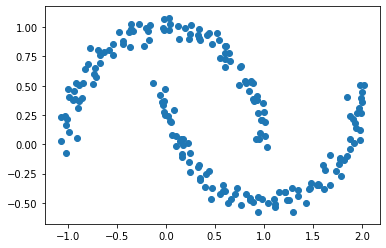

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

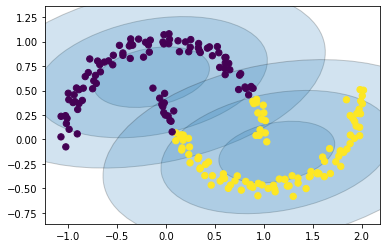

In [15]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

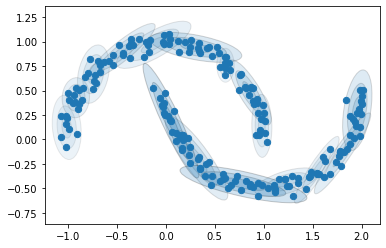

In [16]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

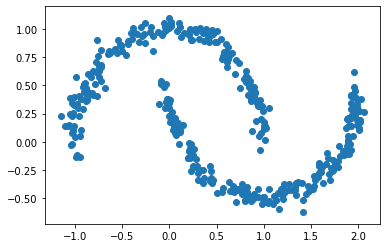

In [17]:
Xnew, labels = gmm16.sample(400)#, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

In [18]:
Xnew[1]

array([-0.77655056,  0.70759433])

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

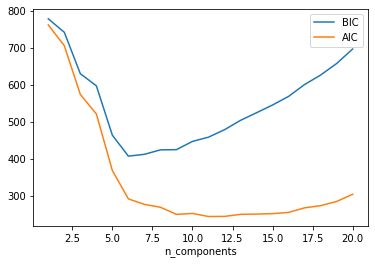

In [19]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [25]:
myGMM?